In [1]:
import numpy as np

import torch
import torch.nn as nn
import math

from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [2]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_LENGTH = 400

In [3]:
imdb_ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers", "tokenizer", "bert-base-uncased"
)

Using cache found in /Users/joyuiyeong/.cache/torch/hub/huggingface_pytorch-transformers_main
/Users/joyuiyeong/.pyenv/versions/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## IMDB 의 DataLoader

In [4]:
def collate_imdb(batch):
    texts, labels = [], []
    for row in batch:
        texts.append(row["text"])
        labels.append(row["label"])

    texts = torch.LongTensor(
        tokenizer(texts, padding=True, truncation=True, max_length=MAX_LENGTH).input_ids
    )
    labels = torch.LongTensor(labels)
    return texts, labels


train_data_loader = DataLoader(
    imdb_ds["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_imdb
)
test_data_loader = DataLoader(
    imdb_ds["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_imdb
)

## Positional Encoding

In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10_000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, None], np.arange(d_model)[None, :], d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

## Multi Head Attention
- Self-attention module을 MHA로 확장하기

1. 기존의 $W_q, W_k, W_v$를 사용하여 $Q, K, V$를 생성합니다.
    1. $Q, K, V \in \mathbb{R}^{S \times D}$가 있을 때, 이를 $Q, K, V \in \mathbb{R}^{S \times H \times D’}$으로 reshape 해줍니다. 여기서 $H$는 `n_heads`라는 인자로 받아야 하고, $D$가 $H$로 나눠 떨어지는 값이여야 하는 제약 조건이 필요합니다. $D = H \times D’$입니다.
    2. $Q, K, V$를 $Q, K, V \in \mathbb{R}^{H \times S \times D’}$의 shape으로 transpose해줍니다.
2. $A = QK^T/\sqrt{D'} \in \mathbb{R}^{H \times S \times S}$를 기존의 self-attention과 똑같이 계산합니다.
3. Mask를 더합니다. 기존과 $A$의 shape이 달라졌기 때문에 dimension을 어떻게 맞춰줘야할지 생각해줘야 합니다.
4. $\hat{x} = \textrm{Softmax}(A)V \in \mathbb{R}^{H \times S \times D'}$를 계산해주고 transpose와 reshape을 통해 $\hat{x} \in \mathbb{R}^{S \times D}$의 shape으로 다시 만들어줍니다.
5. 기존과 똑같이 $\hat{x} = \hat{x} W_o$를 곱해줘서 마무리 해줍니다.

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.wo = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.size()

        # 1. Q, K, V 생성
        Q = self.wq(x)
        K = self.wk(x)
        V = self.wv(x)

        # 1.1 Reshape Q, K, V
        Q = Q.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

        # 2. Attention 점수 계산
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 3. Mask 적용 (필요한 경우)
        if mask is not None:
            # mask shape: [batch_size, 1, 1, seq_length]
            # 마스크를 n_heads 차원으로 확장
            mask = mask.repeat(1, self.n_heads, 1, 1)
            # scores shape: [batch_size, n_heads, seq_length, seq_length]
            scores = scores.masked_fill(mask == 0, -1e9)

        # 4. Softmax 적용 및 Value 와 곱셈
        attention_weights = self.softmax(scores)
        output = torch.matmul(attention_weights, V)

        # 4.1 Transpose 및 Reshape
        output = (
            output.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, self.d_model)
        )

        # 5. 최종 선형 변환
        output = self.wo(output)

        return output

## Transformer Layer

- 다음 내용을 추가하여 Improved Transformer Layer 를 만든다.
    - Layer Normalization
    - Dropout
    - Residual Connection

In [7]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(input_dim, d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
        )

        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout()

    def forward(self, x, mask):
        x1 = self.multi_head_attention(x, mask)
        x1 = self.dropout1(x1)
        x1 = self.layer_norm1(x1 + x)

        x2 = self.ffn(x1)
        x2 = self.dropout2(x2)
        return self.layer_norm2(x2 + x1)

## TextClassifier

In [8]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dff, max_len):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dff = dff
        self.max_len = max_len

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(positional_encoding(max_len, d_model))

        self.layers = nn.ModuleList(
            [TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)]
        )

        self.classification = nn.Linear(d_model, 1)

    def forward(self, x):
        mask = (x != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        seq_len = x.shape[1]

        x = self.embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)
        return x

In [9]:
my_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


def accuracy(m, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(my_device), labels.to(my_device)

        preds = m(inputs)
        # preds = torch.argmax(preds, dim=-1)
        preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

## 학습

In [10]:
model = TextClassifier(
    vocab_size=len(tokenizer),
    d_model=32,
    n_layers=5,
    n_heads=4,
    dff=32,
    max_len=MAX_LENGTH,
).to(my_device)

In [11]:
from torch.optim import Adam

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
n_epochs = 50

train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0.0
    model.train()
    for data in train_data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(my_device), labels.to(my_device).float()

        optimizer.zero_grad()

        outputs = model(inputs)
        predictions = outputs.squeeze()

        loss = criterion(predictions, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_data_loader)
        train_accuracies.append(train_acc)
        test_acc = accuracy(model, test_data_loader)
        test_accuracies.append(test_acc)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   1 | Train Loss: 214.41959223151207
=========> Train acc: 0.835 | Test acc: 0.797
Epoch   2 | Train Loss: 147.44983944296837
=========> Train acc: 0.883 | Test acc: 0.821
Epoch   3 | Train Loss: 115.96052115410566
=========> Train acc: 0.919 | Test acc: 0.829
Epoch   4 | Train Loss: 94.66935334354639
=========> Train acc: 0.943 | Test acc: 0.833
Epoch   5 | Train Loss: 72.82877895236015
=========> Train acc: 0.965 | Test acc: 0.833
Epoch   6 | Train Loss: 54.51769855432212
=========> Train acc: 0.979 | Test acc: 0.829
Epoch   7 | Train Loss: 41.27058403380215
=========> Train acc: 0.983 | Test acc: 0.826
Epoch   8 | Train Loss: 33.754251757171005
=========> Train acc: 0.987 | Test acc: 0.827
Epoch   9 | Train Loss: 27.58564693108201
=========> Train acc: 0.986 | Test acc: 0.819
Epoch  10 | Train Loss: 23.89731530798599
=========> Train acc: 0.992 | Test acc: 0.824
Epoch  11 | Train Loss: 19.70035013370216
=========> Train acc: 0.992 | Test acc: 0.823
Epoch  12 | Train Loss: 20.6

## Accuracy 그래프

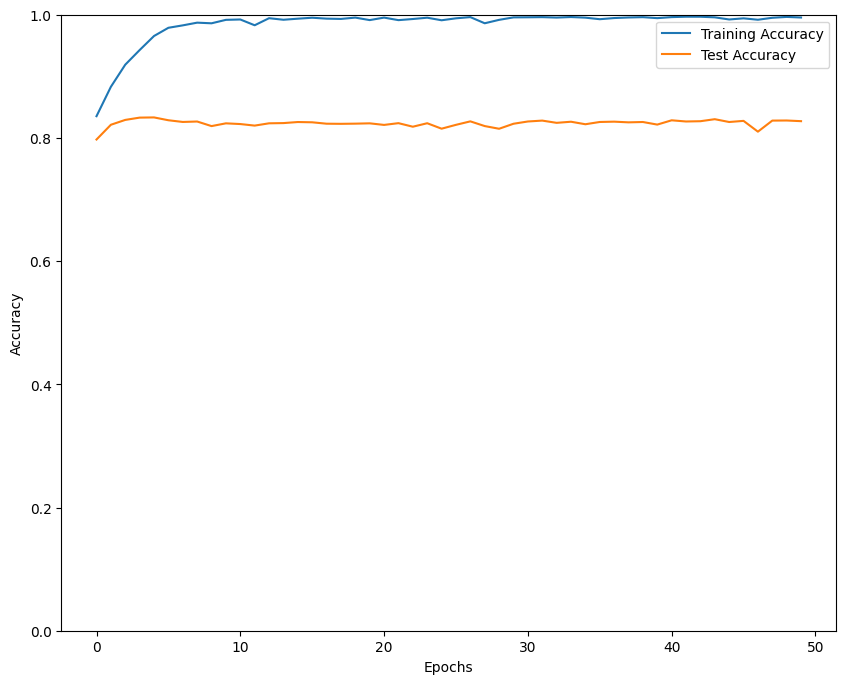

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

x_axis = np.arange(len(train_accuracies))
plt.plot(x_axis, train_accuracies, label="Training Accuracy")
plt.plot(x_axis, test_accuracies, label="Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

## 학습 결과 분석

- 초기 에폭에서 train loss가 급격히 감소하고 train accuracy가 빠르게 증가합니다.
- 약 10 에폭 이후부터는 학습 속도가 완만해지며, train loss와 accuracy의 변화가 작아집니다.
- Train accuracy는 계속 증가하여 최종적으로 99.5% 이상에 도달하지만, test accuracy는 약 82-83% 수준에서 정체됩니다.
- 이는 모델이 overfitting 되었음을 나타냅니다.
